# Runinng a backward pass through LeNet using MNIST and Joey

In this notebook, we will construct LeNet using Joey and run a backward pass through it with some training data from MNIST.

The aim of a backward pass is calculating gradients of all network parameters necessary for later weight updates done by a PyTorch optimizer. A backward pass follows a forward pass.

Firstly, let's import the required prerequisites:

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import joey as ml
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Then, let's define `imshow()` allowing us to look at the training data we'll use for the backward pass.

In [14]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In this particular example, every training batch will have 4 images.

In [15]:
batch_size = 4

Once we have `imshow()` and `batch_size` defined, we'll download the MNIST images using PyTorch.

In [16]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
dataiter = iter(trainloader)

In our case, only one batch will be used for the backward pass. Joey accepts only NumPy arrays, so we have to convert PyTorch tensors to their NumPy equivalents first.

In [17]:
images, labels = dataiter.next()
input_data = images.numpy()

For reference, let's have a look at our training data. There are 4 images corresponding to the following digits: 5, 0, 4, 1.

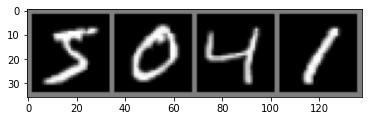

In [18]:
imshow(torchvision.utils.make_grid(images))

At this point, we're ready to define `backward_pass()` running the backward pass through Joey-constructed LeNet. We'll do so using the `Conv`, `MaxPooling`, `Flat`, `FullyConnected` and `FullyConnectedSoftmax` layer classes along with the `Net` class packing everything into one network we can interact with.

Note that a loss function has to be defined manually. Joey doesn't provide any built-in options here at the moment.

In [19]:
def backward_pass(input_data, expected_results):
    # Six 3x3 filters, activation RELU
    layer1 = ml.Conv(kernel_size=(6, 3, 3),
                     input_size=(batch_size, 1, 32, 32),
                     activation=ml.activation.ReLU())
    # Max 2x2 subsampling
    layer2 = ml.MaxPooling(kernel_size=(2, 2),
                           input_size=(batch_size, 6, 30, 30),
                           stride=(2, 2))
    # Sixteen 3x3 filters, activation RELU
    layer3 = ml.Conv(kernel_size=(16, 3, 3),
                     input_size=(batch_size, 6, 15, 15),
                     activation=ml.activation.ReLU())
    # Max 2x2 subsampling
    layer4 = ml.MaxPooling(kernel_size=(2, 2),
                           input_size=(batch_size, 16, 13, 13),
                           stride=(2, 2),
                           strict_stride_check=False)
    # Full connection (16 * 6 * 6 -> 120), activation RELU
    layer5 = ml.FullyConnected(weight_size=(120, 576),
                               input_size=(576, batch_size),
                               activation=ml.activation.ReLU())
    # Full connection (120 -> 84), activation RELU
    layer6 = ml.FullyConnected(weight_size=(84, 120),
                               input_size=(120, batch_size),
                               activation=ml.activation.ReLU())
    # Full connection (84 -> 10), output layer
    layer7 = ml.FullyConnectedSoftmax(weight_size=(10, 84),
                                      input_size=(84, batch_size))
    # Flattening layer necessary between layer 4 and 5
    layer_flat = ml.Flat(input_size=(batch_size, 16, 6, 6))
    
    layers = [layer1, layer2, layer3, layer4,
              layer_flat, layer5, layer6, layer7]
    
    net = ml.Net(layers)
    outputs = net.forward(input_data)
    
    def loss_grad(layer, expected):
        gradients = []
    
        for b in range(batch_size):
            row = []
            for i in range(10):
                result = layer.result.data[i, b]
                if i == expected[b]:
                    result -= 1
                row.append(result)
            gradients.append(row)
    
        return gradients
    
    net.backward(expected_results, loss_grad)
    
    return (layer1, layer2, layer3, layer4, layer_flat, layer5, layer6, layer7)

Afterwards, we're ready to run the backward pass.

In [20]:
layer1, layer2, layer3, layer4, layer_flat, layer5, layer6, layer7 = backward_pass(images, labels)

/home/utkarsh/PycharmProjects/joeyComp702/venv/lib/python3.8/site-packages/devito/types/grid.py:259: RuntimeWarning: divide by zero encountered in true_divide
  spacing = (np.array(self.extent) / (np.array(self.shape) - 1)).astype(self.dtype)
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


Results are stored in the `kernel_gradients` and `bias_gradients` properties of each layer (where applicable).

In order to check the numerical correctness, we'll create the same network with PyTorch, run a backward pass through it using the same initial weights and data and compare the results with Joey's.

Here's the PyTorch code:

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [22]:
net = Net()
net.double()

with torch.no_grad():
    net.conv1.weight[:] = torch.from_numpy(layer1.kernel.data)
    net.conv1.bias[:] = torch.from_numpy(layer1.bias.data)
    net.conv2.weight[:] = torch.from_numpy(layer3.kernel.data)
    net.conv2.bias[:] = torch.from_numpy(layer3.bias.data)
    net.fc1.weight[:] = torch.from_numpy(layer5.kernel.data)
    net.fc1.bias[:] = torch.from_numpy(layer5.bias.data)
    net.fc2.weight[:] = torch.from_numpy(layer6.kernel.data)
    net.fc2.bias[:] = torch.from_numpy(layer6.bias.data)
    net.fc3.weight[:] = torch.from_numpy(layer7.kernel.data)
    net.fc3.bias[:] = torch.from_numpy(layer7.bias.data)

In [23]:
outputs = net(images.double())
net.zero_grad()
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
loss.backward()

After running the backward pass in PyTorch, we're ready to make comparisons. Let's calculate relative errors between Joey and PyTorch in terms of weight/bias gradients.

In [24]:
layers = [layer1, layer3, layer5, layer6, layer7]
pytorch_layers = [net.conv1, net.conv2, net.fc1, net.fc2, net.fc3]

max_error = 0
index = -1

for i in range(5):
    kernel_grad = layers[i].kernel_gradients.data
    pytorch_kernel_grad = pytorch_layers[i].weight.grad.detach().numpy()
    
    kernel_error = abs(kernel_grad - pytorch_kernel_grad) / abs(pytorch_kernel_grad)
    
    bias_grad = layers[i].bias_gradients.data
    pytorch_bias_grad = pytorch_layers[i].bias.grad.detach().numpy()
    
    bias_error = abs(bias_grad - pytorch_bias_grad) / abs(pytorch_bias_grad)
    
    error = max(np.nanmax(kernel_error), np.nanmax(bias_error))
    print('layers[' + str(i) + '] maximum relative error: ' + str(error))
    
    if error > max_error:
        max_error = error
        index = i

print()
print('Maximum relative error is in layers[' + str(index) + ']: ' + str(max_error))

layers[0] maximum relative error: 21.512285659665025
layers[1] maximum relative error: 1.0
layers[2] maximum relative error: 6.257897821417577e-13
layers[3] maximum relative error: 3.869289466189593e-13
layers[4] maximum relative error: 7.306440459408546e-13

Maximum relative error is in layers[0]: 21.512285659665025


/tmp/ipykernel_810615/2568770388.py:11: RuntimeWarning: invalid value encountered in true_divide
  kernel_error = abs(kernel_grad - pytorch_kernel_grad) / abs(pytorch_kernel_grad)
/tmp/ipykernel_810615/2568770388.py:16: RuntimeWarning: invalid value encountered in true_divide
  bias_error = abs(bias_grad - pytorch_bias_grad) / abs(pytorch_bias_grad)


As we can see, the maximum error is low enough (given floating-point calculation accuracy and the complexity of our network) for Joey's results to be considered correct.